In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import layers, models

In [2]:
# Load the dataset
file_path = 'Merged_GNSS_and_SNR_HKOH.csv'
gnss_data = pd.read_csv(file_path)

In [3]:
# Define numerical and categorical columns
numerical_cols = ['Phase Residual (m)', 'Pseudorange Residual (m)', 
                  'STD of Pseudorange L1 (m)', 'STD of Pseudorange L2 (m)', 
                  'Elevation (¡Æ)', 'Azimuth (¡Æ)', 'SNR(dBHz)']

categorical_cols = ['PRN', 'Signal Type 1', 'Signal Type 2']


In [4]:
# Drop irrelevant or target-related columns from input features
X = gnss_data.drop(columns=['TIME', 'L1 MP(m)', 'C1 Code', 'C2 Code', 'DSI'])


In [5]:

# Target variable (multipath effect on L1 MP)
y = gnss_data['L1 MP(m)']

In [6]:
# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense
X_train_preprocessed = X_train_preprocessed.toarray()  # Convert sparse matrix to dense
X_test_preprocessed = X_test_preprocessed.toarray()    # Convert sparse matrix to dense


# CNN

In [8]:
# Define the CNN model architecture
model = models.Sequential()

# Input layer
model.add(layers.InputLayer(input_shape=(X_train_preprocessed.shape[1],)))

# Reshape layer: CNNs expect a 2D input, so we reshape the 1D feature vector
model.add(layers.Reshape((X_train_preprocessed.shape[1], 1)))

# Convolutional Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))

# Pooling Layer 1
model.add(layers.MaxPooling1D(pool_size=2))

# Convolutional Layer 2
model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))

# Pooling Layer 2
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(1, activation='linear'))  # Output is regression for multipath effect

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,457 (154.13 KB)

 Trainable params: 39,457 (154.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, y_test))

Epoch 1/10
   1/7256 ━━━━━━━━━━━━━━━━━━━━ 10:37 88ms/step - loss: 0.0951 - mean_absolute_error: 0.2580

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7252/7256 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1174

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 0.0293 - mean_absolute_error: 0.1174 - val_loss: 0.0242 - val_mean_absolute_error: 0.1064
Epoch 2/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - loss: 0.0238 - mean_absolute_error: 0.1055 - val_loss: 0.0238 - val_mean_absolute_error: 0.1059
Epoch 3/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 0.0227 - mean_absolute_error: 0.1034 - val_loss: 0.0235 - val_mean_absolute_error: 0.1044
Epoch 4/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 0.0224 - mean_absolute_error: 0.1021 - val_loss: 0.0226 - val_mean_absolute_error: 0.1021
Epoch 5/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 0.0224 - mean_absolute_error: 0.1022 - val_loss: 0.0225 - val_mean_absolute_error: 0.1008
Epoch 6/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 0.0216 - mean_absolute_error: 0.1001 - val_loss: 0.0223 - val_mean_absolute_error: 0.1005
Epoch 7/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 0.0222 - mean_absolute_

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Mean Absolute Error: {test_mae}")

  51/1814 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0191 - mean_absolute_error: 0.0983

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0221 - mean_absolute_error: 0.0997
Test Mean Absolute Error: 0.09916632622480392


# FCNN

In [11]:
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import mean_absolute_error

# Define the Fully Connected Neural Network (FCNN) model
fcnn_model = models.Sequential()

# Input layer
fcnn_model.add(layers.InputLayer(input_shape=(X_train_preprocessed.shape[1],)))

# Fully connected hidden layer 1
fcnn_model.add(layers.Dense(128, activation='relu'))

# Fully connected hidden layer 2
fcnn_model.add(layers.Dense(64, activation='relu'))

# Output layer (regression task for predicting L1 MP)
fcnn_model.add(layers.Dense(1, activation='linear'))

# Compile the model
fcnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
fcnn_model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the FCNN model
fcnn_history = fcnn_model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, y_test))


Epoch 1/10
  15/7256 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0813 - mean_absolute_error: 0.2142

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7253/7256 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0258 - mean_absolute_error: 0.1111

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0258 - mean_absolute_error: 0.1111 - val_loss: 0.0236 - val_mean_absolute_error: 0.1043
Epoch 2/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0223 - mean_absolute_error: 0.1024 - val_loss: 0.0227 - val_mean_absolute_error: 0.1023
Epoch 3/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0223 - mean_absolute_error: 0.1015 - val_loss: 0.0225 - val_mean_absolute_error: 0.1008
Epoch 4/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.0216 - mean_absolute_error: 0.0999 - val_loss: 0.0222 - val_mean_absolute_error: 0.1006
Epoch 5/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0212 - mean_absolute_error: 0.0991 - val_loss: 0.0220 - val_mean_absolute_error: 0.1000
Epoch 6/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0217 - mean_absolute_error: 0.0988 - val_loss: 0.0217 - val_mean_absolute_error: 0.0990
Epoch 7/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0207 - mean_absolute_error: 

In [13]:
# Predict using the FCNN model
y_pred_fcnn = fcnn_model.predict(X_test_preprocessed)

# Calculate MAE for the FCNN
fcnn_mae = mean_absolute_error(y_test, y_pred_fcnn)
print(f"Fully Connected Neural Network MAE: {fcnn_mae}")

1814/1814 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step
Fully Connected Neural Network MAE: 0.09847206456907696


# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

In [15]:
# Train the Decision Tree model
dt_model.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(random_state=42)

In [16]:
# Predict using the Decision Tree model
y_pred_dt = dt_model.predict(X_test_preprocessed)

# Calculate MAE for Decision Tree
dt_mae = mean_absolute_error(y_test, y_pred_dt)
print(f"Decision Tree MAE: {dt_mae}")

Decision Tree MAE: 0.1104526023809934


# Random Forest

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min


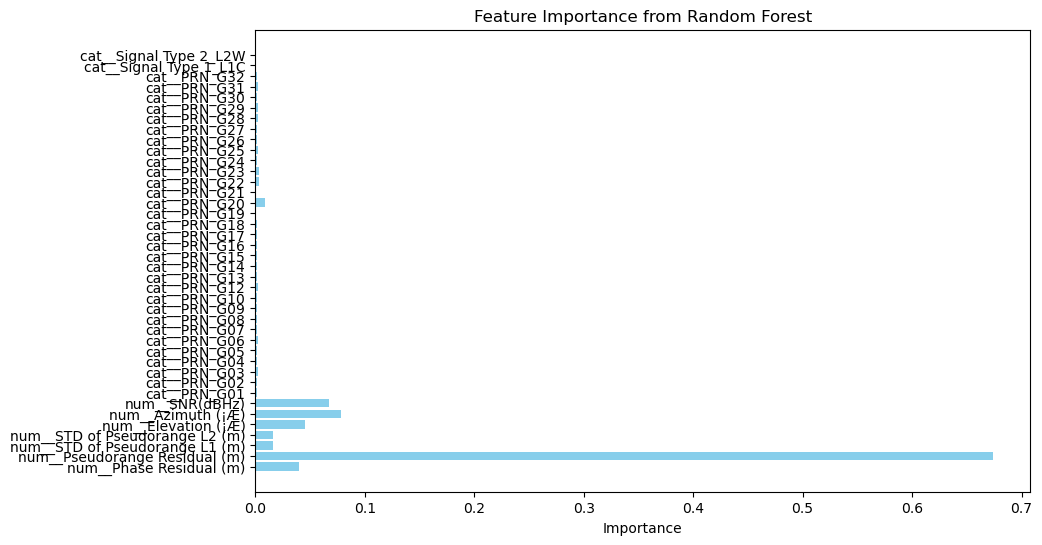

In [17]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)

rf_model.fit(X_train_preprocessed, y_train)
# Extract feature importances
importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

In [18]:
from tqdm import tqdm

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True)

# Initialize tqdm for progress monitoring
with tqdm(total=rf_model.n_estimators, desc="Training Random Forest") as pbar:
    for i in range(1, rf_model.n_estimators + 1):
        # Update the number of trees in the forest
        rf_model.n_estimators = i
        
        # Fit the model with the current number of trees
        rf_model.fit(X_train_preprocessed, y_train)
        
        # Update the progress bar
        pbar.update(1)


Training Random Forest: 100%|█████████████████| 100/100 [02:14<00:00,  1.35s/it]


In [19]:
# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Calculate MAE for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {rf_mae}")

Random Forest MAE: 0.08532709576125691


# RNN

In [20]:
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import mean_absolute_error

# Reshape the preprocessed data to fit the RNN input
# RNN expects input of shape (samples, timesteps, features), where timesteps = 1 in this case
X_train_rnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_rnn = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

# Define the Recurrent Neural Network (RNN) model
rnn_model = models.Sequential()

# Input layer with an LSTM (Long Short-Term Memory) layer
rnn_model.add(layers.LSTM(128, activation='tanh', input_shape=(1, X_train_preprocessed.shape[1])))

# Fully connected hidden layer
rnn_model.add(layers.Dense(64, activation='relu'))

# Output layer (regression task for predicting L1 MP)
rnn_model.add(layers.Dense(1, activation='linear'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
rnn_model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,849 (370.50 KB)

 Trainable params: 94,849 (370.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the RNN model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/10
   6/7256 ━━━━━━━━━━━━━━━━━━━━ 1:25 12ms/step - loss: 0.0667 - mean_absolute_error: 0.2057

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7255/7256 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0259 - mean_absolute_error: 0.1110

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 0.0259 - mean_absolute_error: 0.1110 - val_loss: 0.0233 - val_mean_absolute_error: 0.1040
Epoch 2/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1040 - val_loss: 0.0231 - val_mean_absolute_error: 0.1030
Epoch 3/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 0.0224 - mean_absolute_error: 0.1022 - val_loss: 0.0226 - val_mean_absolute_error: 0.1021
Epoch 4/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 0.0217 - mean_absolute_error: 0.1009 - val_loss: 0.0232 - val_mean_absolute_error: 0.1037
Epoch 5/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1007 - val_loss: 0.0222 - val_mean_absolute_error: 0.1010
Epoch 6/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1003 - val_loss: 0.0220 - val_mean_absolute_error: 0.1000
Epoch 7/10
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 0.0209 - mean_absolute_

In [22]:
# Predict using the RNN model
y_pred_rnn = rnn_model.predict(X_test_rnn)

# Calculate MAE for the RNN
rnn_mae = mean_absolute_error(y_test, y_pred_rnn)
print(f"Recurrent Neural Network MAE: {rnn_mae}")

1814/1814 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Recurrent Neural Network MAE: 0.100882908941388


# SVM

In [23]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Initialize the Support Vector Machine regressor with RBF kernel
svm_model = SVR(kernel='rbf')  # RBF kernel is common for regression tasks

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense
X_train_preprocessed = X_train_preprocessed.toarray()  # Convert sparse matrix to dense
X_test_preprocessed = X_test_preprocessed.toarray()    # Convert sparse matrix to dense

# Subsample the data (e.g., use only 10% of the data)
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_preprocessed, y_train, test_size=0.9, random_state=42)

# Train the SVM model on the subsampled data
svm_model.fit(X_train_sampled, y_train_sampled)


SVR()

In [25]:

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test_preprocessed)

In [26]:
# Calculate the Mean Absolute Error (MAE) for SVM
svm_mae = mean_absolute_error(y_test, y_pred_svm)

print(f"Support Vector Machine MAE: {svm_mae}")

Support Vector Machine MAE: 0.10088340319468443


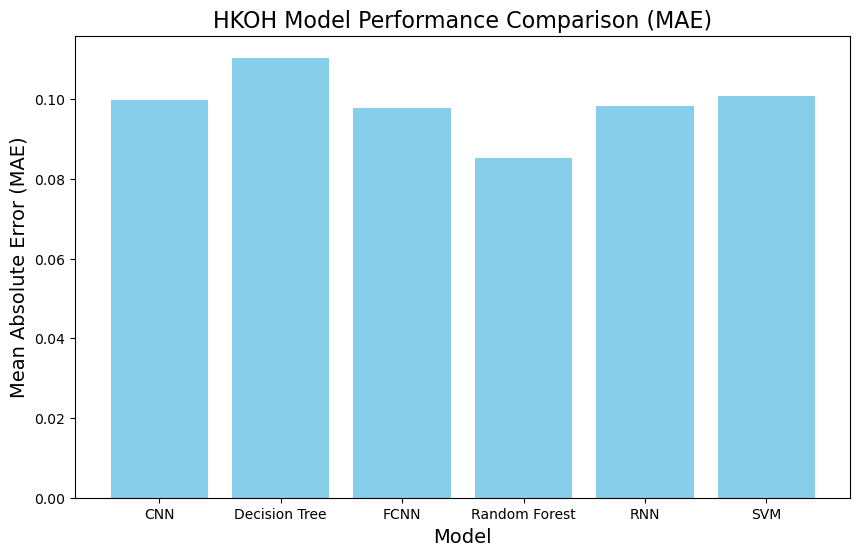

In [27]:
import matplotlib.pyplot as plt

# Replace these with the actual MAE values from your separate notebooks
cnn_mae = 0.09916632622480392  # From CNN_first.ipynb
dt_mae = 0.1104526023809934
fcnn_mae = 0.09847206456907696  # From FCNN.ipynb
random_forest_mae = 0.08532709576125691  # From RandomForest.ipynb
rnn_mae = 0.100882908941388  # From RNN.ipynb
svm_mae = 0.10088340319468443  # From SVM.ipynb

# Dictionary of models and their MAE values
mae_values = {
    "CNN": cnn_mae,
    "Decision Tree": dt_mae,
    "FCNN": fcnn_mae,
    "Random Forest": random_forest_mae,
    "RNN": rnn_mae,
    "SVM": svm_mae
}

# Convert MAE values to lists
models = list(mae_values.keys())
mae_scores = list(mae_values.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mae_scores, color='skyblue')

# Add title and labels
plt.title('HKOH Model Performance Comparison (MAE)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)

# Display the bar chart
plt.show()


/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 232170, number of used features: 38
[LightGBM] [Info] Start training from score -0.002481


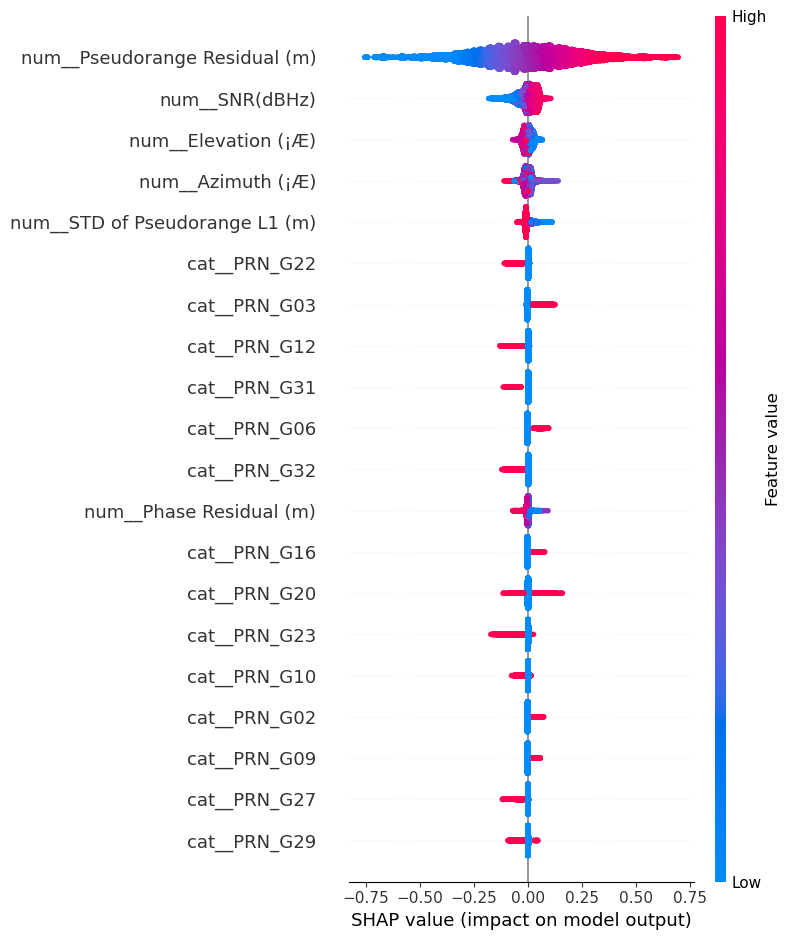

In [28]:
import lightgbm as lgb
import shap

# Train a LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_preprocessed, y_train)

# Use SHAP for feature importance
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)


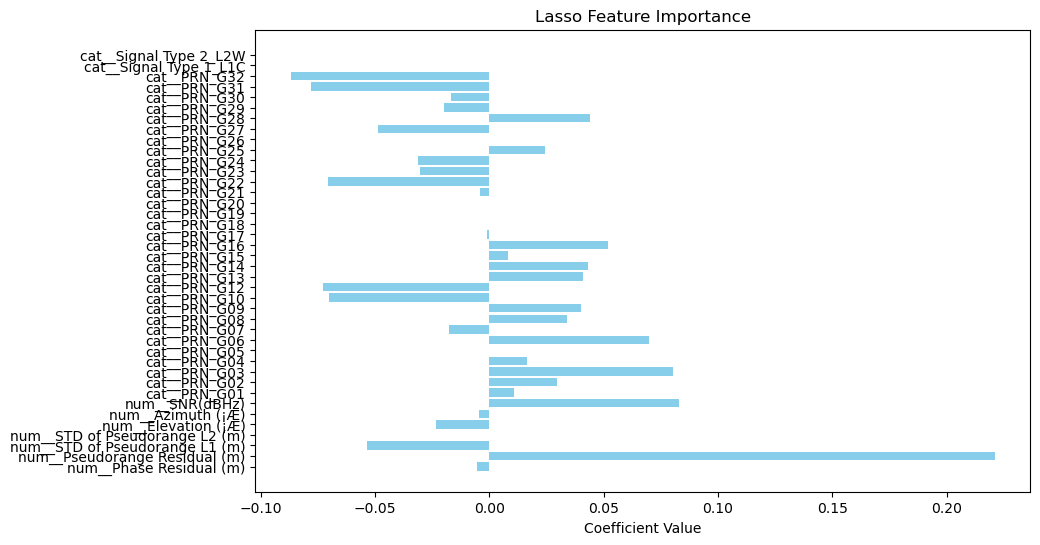

In [29]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# Fit Lasso regression with cross-validation
lasso = LassoCV(cv=5).fit(X_train_preprocessed, y_train)

# Get the feature importance (non-zero coefficients)
coef = lasso.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Feature Importance')
plt.show()


In [30]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

# Use a simpler model for RFE
rfe_model = DecisionTreeRegressor(random_state=42)

# Perform recursive feature elimination
selector = RFE(estimator=rfe_model, n_features_to_select=5, step=2, verbose=1)
selector.fit(X_train_preprocessed, y_train)

# Get ranking of features
ranking = selector.ranking_
# Assuming you have feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Print feature rankings along with feature names
for i in range(len(ranking)):
    print(f"Feature: {feature_names[i]}, Rank: {ranking[i]}")

Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Feature: num__Phase Residual (m), Rank: 1
Feature: num__Pseudorange Residual (m), Rank: 1
Feature: num__STD of Pseudorange L1 (m), Rank: 2
Feature: num__STD of Pseudorange L2 (m), Rank: 3
Feature: num__Elevation (¡Æ), Rank: 1
Feature: num__Azimuth (¡Æ), Rank: 1
Feature: num__SNR(dBHz), Rank: 1
Feature: cat__PRN_G01, Rank: 15
Feature: cat__PRN_G02, Rank

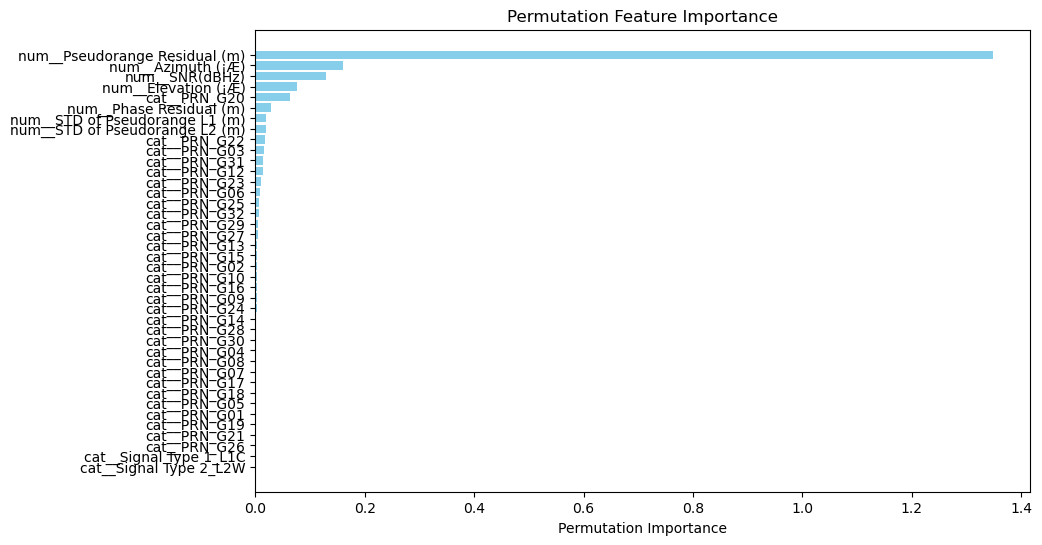

In [31]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Use a subset of the test data to speed up the process
X_test_sampled, _, y_test_sampled, _ = train_test_split(X_test_preprocessed, y_test, test_size=0.8, random_state=42)

# Apply permutation importance
perm_importance = permutation_importance(rf_model, X_test_sampled, y_test_sampled, n_repeats=5, random_state=42)

# Sort and plot the results
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.show()
